<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/HCP_ANN_Connectiviy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 🧠 Compute EC(t) for each subject using NPI.model_ECt
# ============================================

# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 203 (delta 16), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (203/203), 28.16 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (57/57), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [ ]:
# --- 8️⃣ Main EC(t) extraction loop ---
pert_strength = 0.1
ECts = {}

for sid in subjects:
    print(f"\n================ {sid} ================")

    sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
    inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
    tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
    mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

    if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
        print(f"❌ Missing data or model for {sid}")
        continue

    # Load fMRI windows
    Z = np.load(sig_path)             # (T, N)
    X = np.load(inp_path)             # (M, S*N)
    Y = np.load(tgt_path)             # (M, N)

    # Load model
    model = load_model(mdl_path, X, Y)
    print("🧩 Model loaded.")

    # Compute EC(t)
    EC_t = NPI.model_ECt(model, input_X=X[:500,:], target_Y=Y[:500,:], pert_strength=pert_strength)
    ECts[sid] = EC_t
    print(f"✅ EC(t) computed: {EC_t.shape}")

    # Save
    out_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    np.save(out_path, EC_t)
    print(f"💾 Saved EC(t) → {out_path}")

    del Z, X, Y, model, EC_t
    gc.collect(); torch.cuda.empty_cache()

print("\n🎯 All subjects processed successfully.")





================ id_100206 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100206_ECt.npy

================ id_100307 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100307_ECt.npy

================ id_100408 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100408_ECt.npy

================ id_101006 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_101006_ECt.npy

================ id_101107 ================
🧩 Model loaded.
✅ EC(t) computed: (500, 450, 450)
💾 Saved EC(t) → /content/driv

# Single Subject Example

In [2]:
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

In [3]:
Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [5]:
S=3 #number of steps
N=Z.shape[1] #number of regions

(4603, 450)

In [6]:
EC_t = NPI.model_ECt(model, input_X=X[:3000,:], target_Y=Y[:3000,:], pert_strength=0.1)

In [7]:
EC_t.shape

(3000, 450, 450)

Pearson correlation between energy and mean|EC|: r = -0.517, p = 6.62e-205


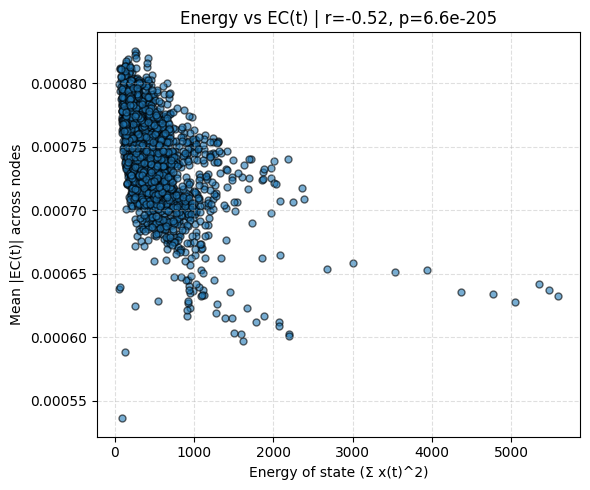

In [8]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------
# Assume you already have:
#   EC_t : np.ndarray (M, N, N)
#   X    : np.ndarray (M, S*N)
# --------------------------------------------

M, N = EC_t.shape[0], EC_t.shape[1]
S = X[:3000,:].shape[1] // N

# --- 1️⃣ Extract x(t) for each time window ---
# The last N elements of each flattened window correspond to the most recent state
x_t = X[:3000,-N:]   # shape (M, N)

# --- 2️⃣ Compute energy of state at time t ---
E_t = np.sum(x_t**2, axis=1)   # shape (M,)

# --- 3️⃣ Compute mean absolute EC magnitude per time point ---
EC_mean_t = np.mean(np.abs(EC_t), axis=(1, 2))   # shape (M,)

# --- 4️⃣ Correlate across time points ---
r, p = pearsonr(E_t, EC_mean_t)
print(f"Pearson correlation between energy and mean|EC|: r = {r:.3f}, p = {p:.3g}")

# --- 5️⃣ Plot relationship ---
plt.figure(figsize=(6, 5))
plt.scatter(E_t, EC_mean_t, s=25, alpha=0.6, edgecolors='k')
plt.xlabel("Energy of state (Σ x(t)^2)")
plt.ylabel("Mean |EC(t)| across nodes")
plt.title(f"Energy vs EC(t) | r={r:.2f}, p={p:.2g}")
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()


EC_t shape: (3000, 450, 450)


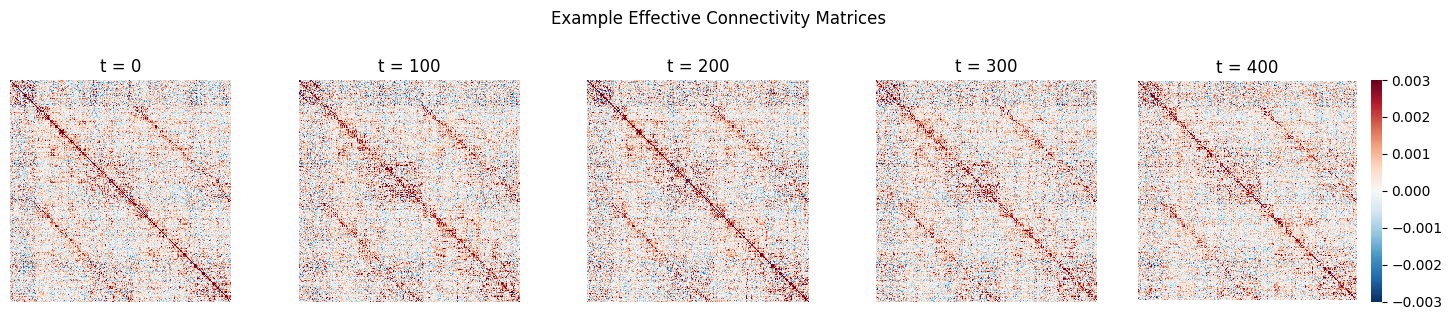

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume EC_t is already loaded and has shape (3000, 450, 450)
print("EC_t shape:", EC_t.shape)

# Select time points to visualize
times = [0, 100, 200, 300, 400]

# Plot parameters
vmin, vmax = -0.003, 0.003
cmap = "RdBu_r"  # reversed so red = positive, blue = negative

# Create figure
fig, axes = plt.subplots(1, len(times), figsize=(15, 3))

for i, t in enumerate(times):
    ax = axes[i]
    sns.heatmap(
        EC_t[t],
        ax=ax,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar=(i == len(times) - 1),  # show colorbar only on last
        square=True,
        xticklabels=False,
        yticklabels=False
    )
    ax.set_title(f"t = {t}")

plt.suptitle("Example Effective Connectivity Matrices", fontsize=12, y=1.05)
plt.tight_layout()
plt.show()


# Bifocal Effective Connectivity

In [ ]:
# --- 8️⃣ Main BEC(t) extraction loop ---
pert_strength = 0.1
BECts = {}

for sid in subjects:
    print(f"\n================ {sid} ================")

    sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
    inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
    tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
    mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

    if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
        print(f"❌ Missing data or model for {sid}")
        continue

    # Load fMRI windows
    Z = np.load(sig_path)             # (T, N)
    X = np.load(inp_path)             # (M, S*N)
    Y = np.load(tgt_path)             # (M, N)

    # Load model
    model = load_model(mdl_path, X, Y)
    print("🧩 Model loaded.")

    # Compute EC(t)
    BEC_t = NPI.model_BECt(model, input_X=X[:500,:], target_Y=Y[:500,:], pert_strength=pert_strength, metric='l2')
    BECts[sid] = BEC_t
    print(f"✅ BEC(t) computed: {BEC_t.shape}")

    # Save
    out_path = os.path.join(ects_dir, f"{sid}_BECt.npy")
    np.save(out_path, BEC_t)
    print(f"💾 Saved BEC(t) → {out_path}")

    del Z, X, Y, model, BEC_t
    gc.collect(); torch.cuda.empty_cache()

print("\n🎯 All subjects processed successfully.")


================ id_100206 ================
🧩 Model loaded.
✅ BEC(t) computed: (500, 450, 450)
💾 Saved BEC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100206_BECt.npy

================ id_100307 ================
🧩 Model loaded.


KeyboardInterrupt: 